# This Kaggle notebook includes code to extract features using Inception V3 Net model and plotting feature maps. Uses rotation invariant augmentation.



***Steps to get started***

Execute this notebook in Kaggle. 
Login to Kaggle account and click on "New Notebook".
From File menu, select "Import notebook", and drag and drop this notebook file to it.
Click on any cell to start session.
On the right pane, you will find "Add Data" . On the search icon give the below url (of the dataset) and select this dataset from the search results. Click the "+" icon to add this dataset to your notebook session.

Dataset - https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')



In [2]:
os.listdir('../input')

['pulmonary-chest-xray-abnormalities']

In [3]:
os.listdir('../input/pulmonary-chest-xray-abnormalities')

['ChinaSet_AllFiles', 'Montgomery']

In [4]:
shen_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

In [5]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [6]:
df_shen.head()

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png


In [7]:
df_mont.head()

,image_id
0,MCUCXR_0017_0.png
1,MCUCXR_0020_0.png
2,MCUCXR_0030_0.png
3,MCUCXR_0013_0.png
4,MCUCXR_0354_1.png


In [8]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [9]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [10]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [11]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

Function to display the images in datasets

In [12]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

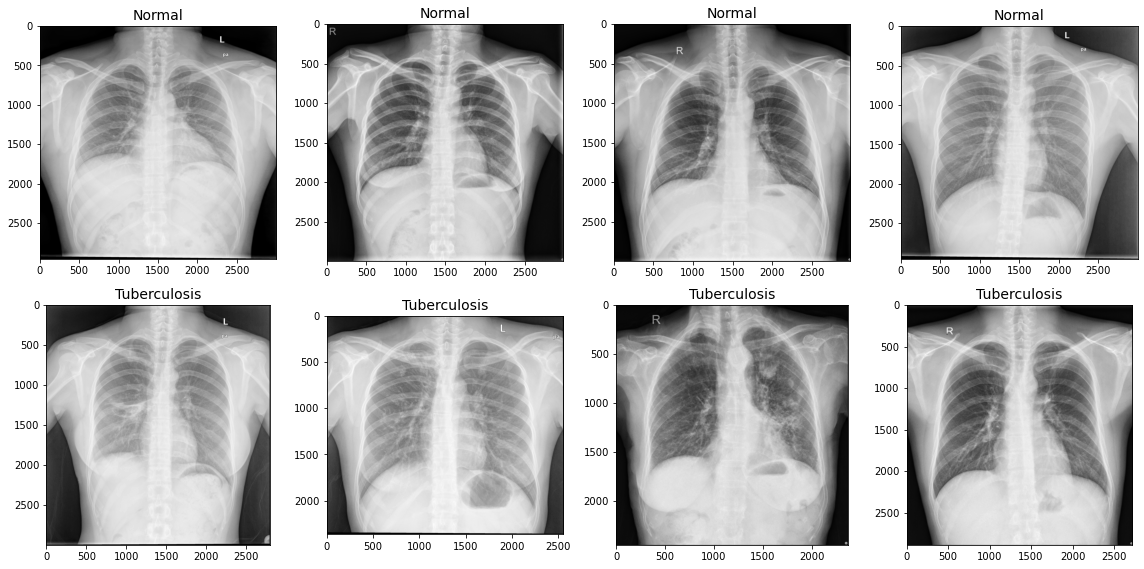

In [13]:
# Shenzen Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

Visualizing the Montgomery dataset images

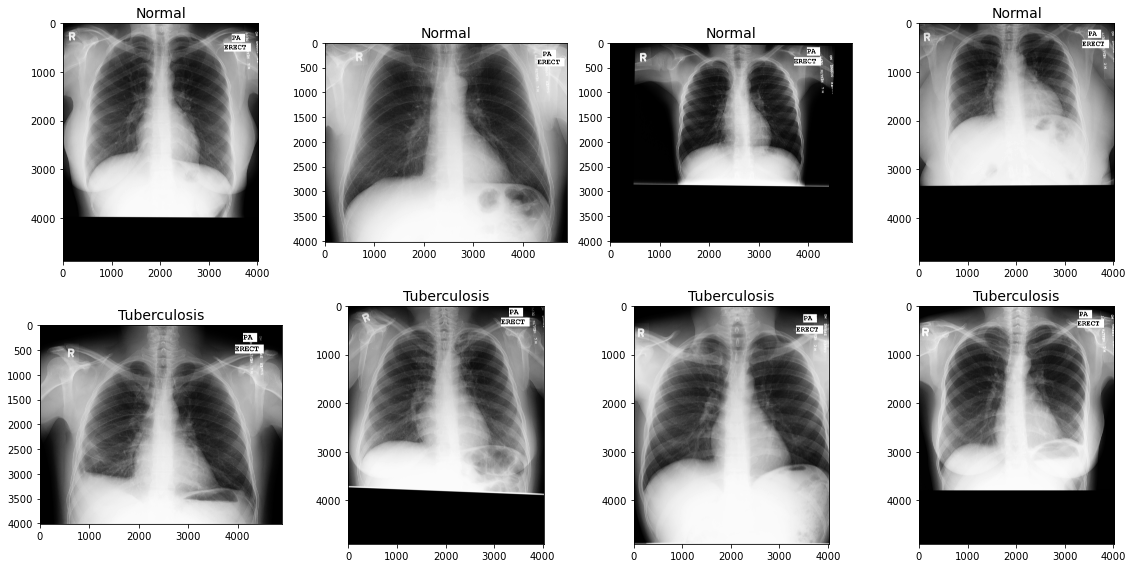

In [14]:
# Montgomery Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

# EDA Exploratory Data Analysis

In [15]:
#EDA

def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output


In [16]:
# w = width, h= height, c= number of channels of image
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0092_0.png,Normal,2652,2796,3,255,0
1,CHNCXR_0322_0.png,Normal,2949,3000,3,255,0
2,CHNCXR_0304_0.png,Normal,2945,3000,3,255,0
3,CHNCXR_0572_1.png,Tuberculosis,2289,2400,3,255,0
4,CHNCXR_0547_1.png,Tuberculosis,2823,2610,3,255,0


In [17]:
# w = width, h= height, c= number of channels of image; for Montgomery
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0017_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0020_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0030_0.png,Normal,4020,4892,3,255,0
3,MCUCXR_0013_0.png,Normal,4020,4892,3,255,0
4,MCUCXR_0354_1.png,Tuberculosis,4020,4892,3,252,0


In [18]:
df_shen['c'].value_counts()

3    662
Name: c, dtype: int64

In [19]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

In [20]:
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [21]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

Label creation

In [22]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [23]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
287,CHNCXR_0155_0.png,Normal,1737,2253,3,255,0,0
367,CHNCXR_0433_1.png,Tuberculosis,2942,3001,3,255,0,1
696,MCUCXR_0035_0.png,Normal,4892,4020,3,255,0,0
513,CHNCXR_0108_0.png,Normal,2953,2897,3,255,0,0
89,CHNCXR_0602_1.png,Tuberculosis,2539,2299,3,255,0,1


Splitting data into train and test split

In [24]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [25]:
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [26]:
df_train.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
562,CHNCXR_0452_1.png,Tuberculosis,2804,2423,3,255,0,1
792,MCUCXR_0028_0.png,Normal,4892,4020,3,255,0,0
405,CHNCXR_0574_1.png,Tuberculosis,2991,2609,3,255,0,1
147,CHNCXR_0555_1.png,Tuberculosis,2606,2497,3,255,8,1
377,CHNCXR_0550_1.png,Tuberculosis,2751,2521,3,249,0,1


In [27]:
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

CREATE FOLDERS INSIDE THE BASE DIRECTORY - to arrange train images and validation images in respective folders

In [28]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


In [29]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [30]:
# We will resize the images to 299 x 299 as expected by the Inception model.
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299

In [31]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [32]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

345
335


In [33]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


# Rotation Invariant Augmentation in one step, without using keras aug steps

In [34]:
import os
import random
import numpy as np
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import cv2
import skimage.io
import skimage.transform

def gkernel(l=3, sig=0.3):
    """\
    Gaussian Kernel Creator via given length and sigma
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)



def shear(image_array: ndarray):
  rows, cols, dim = image_array.shape
  # transformation matrix for Shearing
  # shearing applied to x-axis
  # shear value as given in paper 0.2 and 0.4
  M = np.float32([[1, 0, 0],
              [0.2, 1  , 0],
              [0, 0  , 1]])
  # shearing applied to y-axis
  M = np.float32([[1,   0, 0],
                  [0.4, 1, 0],
                  [0,   0, 1]])
  # apply a perspective transformation to the image                
  sheared_img = cv2.warpPerspective(image_array,M,(int(cols*1.5),int(rows*1.5)))
  return sheared_img  


def gaus_filt(gray, g_kernel = gkernel(3,2)):
  gaus = cv2.filter2D(gray,-1,g_kernel) #convolve kernel with image
  return gaus     


    
# dictionary of the transformations; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Normal'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)

    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    

    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [35]:
# Check how many train images we now have in folder.
# This is the original images plus the augmented images.
print(len(os.listdir('base_dir/train_dir/Normal')))

1846


In [36]:
# for Tuberculosis class

# dictionary of the transformations ; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Tuberculosis'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
  
    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [37]:
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1836


In [38]:
#check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


To plot the augmented images in Normal class

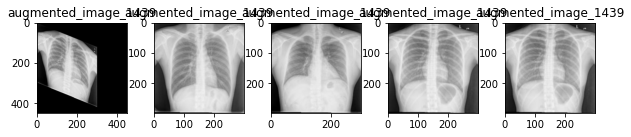

In [39]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Normal/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Normal/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)
      



To plot the augmented images in Tuberculosis class

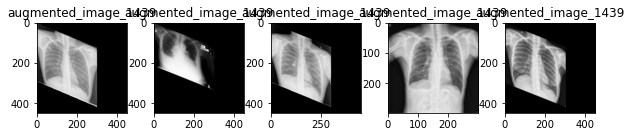

In [40]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Tuberculosis/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Tuberculosis/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)
      

# Feature Extraction using Inception v3 Net

In [41]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential


from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense,Activation,AveragePooling2D,MaxPool2D, Dropout, Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
import glob
import skimage

def loadImages(path):
    '''
        parameters
        ----------
        path : input path of the images
        
        returns
        -------
        loadedImages : list of loaded images 
    '''
    sample = []
    
    for filename in glob.glob(path):
        
        img = cv2.imread(filename)
        img = skimage.transform.resize(img, (299, 299, 3))        
        IMG = np.array(img,dtype=np.float64)
        
        
        sample.append(IMG)
        
    return sample

In [43]:
# our code for train and test paths

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

In [44]:
train_path1 = 'base_dir/train_dir/Normal/*.png'
train_path2 = 'base_dir/train_dir/Tuberculosis/*.png'

train_path3 = 'base_dir/train_dir/Normal/augmented_image_*'
train_path4 = 'base_dir/train_dir/Tuberculosis/augmented_image_*'

valid_path1 = 'base_dir/val_dir/Normal/*.png'
valid_path2 = 'base_dir/val_dir/Tuberculosis/*.png'

In [45]:
train_N = loadImages(train_path1)
train_TB = loadImages(train_path2)

train_N_aug = loadImages(train_path3) 
train_TB_aug= loadImages(train_path4)

valid_N = loadImages(valid_path1)
valid_TB = loadImages(valid_path2)

In [46]:
#%% CREATION OF DATASETS FOR FEATURE EXTRACTION

df_train_N = pd.DataFrame({'image':train_N, 'label': 'Normal'})
df_train_TB = pd.DataFrame({'image':train_TB, 'label': 'Tuberculosis'})
df_train_N_aug = pd.DataFrame({'image':train_N_aug, 'label': 'Normal'})
df_train_TB_aug = pd.DataFrame({'image':train_TB_aug, 'label': 'Tuberculosis'})


df_valid_N = pd.DataFrame({'image':valid_N, 'label': 'Normal'})
df_valid_TB = pd.DataFrame({'image':valid_TB, 'label': 'Tuberculosis'})

In [47]:
final_data = [df_train_N, df_train_TB, df_train_N_aug,df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

Entire data size: (3802, 2)


In [48]:
temp_N = df_train_N_aug.head(9)
temp_N.shape

(9, 2)

In [49]:
temp_TB = df_train_TB_aug.head(9)
temp_TB.shape

(9, 2)

In [50]:
#%% CREATION OF DATASETS FOR FEATURE EXTRACTION

df_train_N = pd.DataFrame({'image':train_N, 'label': 'Normal'})
df_train_TB = pd.DataFrame({'image':train_TB, 'label': 'Tuberculosis'})
df_train_N_aug = pd.DataFrame({'image':train_N_aug, 'label': 'Normal'})
df_train_TB_aug = pd.DataFrame({'image':train_TB_aug, 'label': 'Tuberculosis'})


df_valid_N = pd.DataFrame({'image':valid_N, 'label': 'Normal'})
df_valid_TB = pd.DataFrame({'image':valid_TB, 'label': 'Tuberculosis'})

In [125]:
final_data = [temp_N,temp_TB,df_train_N_aug, df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

Entire data size: (3140, 2)


In [52]:
#%% TRAIN LABEL SEPARATION

train_data = final_data['image']
labels = final_data['label']

In [53]:
# ENCODING the LABELS

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

final_data['label'] = le.fit_transform(final_data['label'])
final_data.head()

,image,label
0,"[[[0.23066949166380343, 0.23066949166380343, 0...",0
1,"[[[0.3764705882352941, 0.3764705882352941, 0.3...",0
2,"[[[0.21568627450980393, 0.21568627450980393, 0...",0
3,"[[[0.21176470588235294, 0.21176470588235294, 0...",0
4,"[[[0.21176470588235294, 0.21176470588235294, 0...",0


In [54]:
labels = final_data['label']

In [55]:
#%% LOOKING AT THE AMOUNT OF ITEMS PER CLASS 

from collections import Counter
print("Labels Count:",Counter(np.array(labels)))

Labels Count: Counter({0: 1571, 1: 1569})


In [56]:
final_data['label']

0     0
1     0
2     0
3     0
4     0
     ..
54    1
55    1
56    1
57    1
58    1
Name: label, Length: 3140, dtype: int64

In [57]:
final_data['label'].dtype

dtype('int64')

In [58]:
labels

0     0
1     0
2     0
3     0
4     0
     ..
54    1
55    1
56    1
57    1
58    1
Name: label, Length: 3140, dtype: int64

In [59]:
#%% SPLITTING INTO TRAIN AND TEST SET, TRAIN SET WILL BE FURTHER SPLIT INTO TRAIN AND VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train_data, labels,
                                                  test_size = 0.2,
                                                  stratify = labels,
                                                  shuffle = True,
                                                  random_state = 42)

print('length X_train:', len(X_train))
print('length y_train:', len(y_train))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 2512
length y_train: 2512
length X_test: 628
length y_test: 628


In [60]:
X_train.shape

(2512,)

In [61]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [62]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [63]:
y_test

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,

What does enumerate do in Python? The enumerate function in Python converts a data collection object into an enumerate object. Enumerate returns an object that contains a counter as a key for each value within an object, making items within the collection easier to access.

like assigning index for easy access. (students roll number).

In [64]:
x_train= np.empty((len(X_train),X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2]))
for i,x in enumerate(X_train):
    x_train[i]=X_train[i]
print(x_train.shape)

(2512, 299, 299, 3)


In [65]:
x_test= np.empty((len(X_test),X_test[0].shape[0],X_test[0].shape[1],X_test[0].shape[2]))
for i,x in enumerate(X_test):
    x_test[i]=X_test[i]
print(x_test.shape)

(628, 299, 299, 3)


# Feature Extraction using Inception Net

In [66]:
inp_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3), pooling='max')


2023-01-31 03:32:05.740266: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


87924736/87910968 [==============================] - 4s 0us/step


In [67]:
inp_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [68]:
# summarize feature map shapes
for i in range(len(inp_model.layers)):
    layer = inp_model.layers[i]
    # check for batch_normalization_ layer
    if 'batch_normalization_' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

5 batch_normalization_1 (None, 147, 147, 32)
8 batch_normalization_2 (None, 147, 147, 64)
12 batch_normalization_3 (None, 73, 73, 80)
15 batch_normalization_4 (None, 71, 71, 192)
19 batch_normalization_8 (None, 35, 35, 64)
23 batch_normalization_6 (None, 35, 35, 48)
24 batch_normalization_9 (None, 35, 35, 96)
32 batch_normalization_5 (None, 35, 35, 64)
33 batch_normalization_7 (None, 35, 35, 64)
34 batch_normalization_10 (None, 35, 35, 96)
35 batch_normalization_11 (None, 35, 35, 32)
42 batch_normalization_15 (None, 35, 35, 64)
46 batch_normalization_13 (None, 35, 35, 48)
47 batch_normalization_16 (None, 35, 35, 96)
55 batch_normalization_12 (None, 35, 35, 64)
56 batch_normalization_14 (None, 35, 35, 64)
57 batch_normalization_17 (None, 35, 35, 96)
58 batch_normalization_18 (None, 35, 35, 64)
65 batch_normalization_22 (None, 35, 35, 64)
69 batch_normalization_20 (None, 35, 35, 48)
70 batch_normalization_23 (None, 35, 35, 96)
78 batch_normalization_19 (None, 35, 35, 64)
79 batch_normali

In [69]:

# redefine model to output right after the 305th (batch_normalization_93) layer
incep_feat_model = Model(inputs=inp_model.inputs, outputs=inp_model.layers[305].output)

In [70]:
x_train_feat_inp = incep_feat_model.predict(x_train)


2023-01-31 03:32:22.054426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [71]:
x_train_feat_inp.shape

(2512, 8, 8, 192)

In [72]:
x_val_feat_inp = incep_feat_model.predict(x_test)


In [116]:
x_val_feat_inp

array([[[[-6.87106624e-02, -5.80704629e-01,  4.62031990e-01, ...,
          -5.06256998e-01,  3.97537738e-01,  1.18399751e+00],
         [-9.30684358e-02, -9.54840481e-01,  7.36301243e-01, ...,
          -4.11676913e-01,  7.37931490e-01,  1.58748889e+00],
         [-4.08725500e-01, -1.29273844e+00,  9.69684541e-01, ...,
          -1.64898381e-01,  1.00086129e+00,  2.02300382e+00],
         ...,
         [-2.92676598e-01, -1.23812234e+00,  1.28158569e+00, ...,
          -1.91667855e-01,  8.51289555e-02,  9.19154286e-01],
         [-6.20562136e-02, -1.04761791e+00,  1.10507512e+00, ...,
          -1.09055430e-01,  1.52538612e-01,  7.32961535e-01],
         [-1.45873681e-01, -9.50939834e-01,  7.95306265e-01, ...,
          -1.60058029e-02,  2.93531150e-01,  2.80706674e-01]],

        [[ 3.45980853e-01, -5.71648061e-01,  7.75812566e-01, ...,
           2.76315119e-02, -5.46976328e-02,  1.48441446e+00],
         [ 3.34779769e-01, -9.39550996e-01,  1.09443688e+00, ...,
           9.06409919e

In [97]:
x_val_feat_inp.shape

(628, 8, 8, 192)

# Visualize Batch Normalization Layer features for the Inception V3 Net

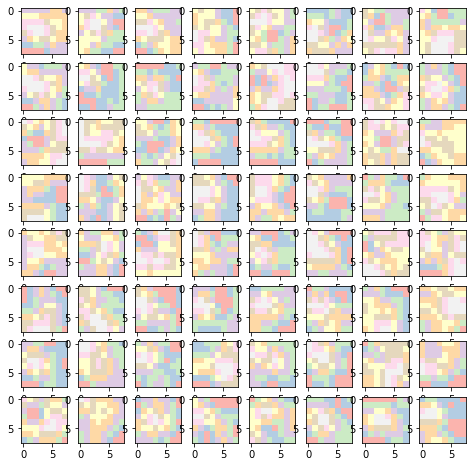

In [74]:

layer_outputs = [layer.output for layer in inp_model.layers]
activation_model = Model(inputs = inp_model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[10].reshape(1,299,299,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*1,col_size*1))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='Pastel1')
            activation_index += 1
# batch_normalization_93
display_activation(activations, 8, 8, 305)

 The number of feature maps (e.g. depth or number of channels) in deeper layers is much more than 64, such as 256 or 512. Nevertheless, we can cap the number of feature maps visualized at 64 for consistency.

Inference from feature maps

Initial layers are more interpretable and retain the majority of the features in the input image. As the level of the layer increases, features become less interpretable, they become more abstract and they identify features specific to the class leaving behind the general features of the image.

# Saving features

In [114]:
import os
os.listdir('/kaggle/working/base_dir')

['val_dir', 'train_dir']

In [101]:
np.save('x_train_feat_inp.npy', x_train_feat_inp)

In [104]:
os.listdir('/kaggle/working/base_dir/val_dir')

['Normal', 'Tuberculosis']

In [103]:
pwd

'/kaggle/working'

In [102]:
np.save('x_val_feat_inp.npy', x_val_feat_inp)


array([[[[-6.87106624e-02, -5.80704629e-01,  4.62031990e-01, ...,
          -5.06256998e-01,  3.97537738e-01,  1.18399751e+00],
         [-9.30684358e-02, -9.54840481e-01,  7.36301243e-01, ...,
          -4.11676913e-01,  7.37931490e-01,  1.58748889e+00],
         [-4.08725500e-01, -1.29273844e+00,  9.69684541e-01, ...,
          -1.64898381e-01,  1.00086129e+00,  2.02300382e+00],
         ...,
         [-2.92676598e-01, -1.23812234e+00,  1.28158569e+00, ...,
          -1.91667855e-01,  8.51289555e-02,  9.19154286e-01],
         [-6.20562136e-02, -1.04761791e+00,  1.10507512e+00, ...,
          -1.09055430e-01,  1.52538612e-01,  7.32961535e-01],
         [-1.45873681e-01, -9.50939834e-01,  7.95306265e-01, ...,
          -1.60058029e-02,  2.93531150e-01,  2.80706674e-01]],

        [[ 3.45980853e-01, -5.71648061e-01,  7.75812566e-01, ...,
           2.76315119e-02, -5.46976328e-02,  1.48441446e+00],
         [ 3.34779769e-01, -9.39550996e-01,  1.09443688e+00, ...,
           9.06409919e

In [109]:
cd '/kaggle/working'

/kaggle/working


In [112]:
!ls

__notebook_source__.ipynb  x_train_feat_inp.npy  x_val_feat_inp.pkl
base_dir		   x_val_feat_inp.npy


In [111]:
os.makedirs('../outputs')

# Classification Neural Network

In [115]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Activation

import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPool2D, Dropout, Activation, AvgPool2D
from keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
#from keras.optimizers import RMSprop, Adam
#tf.keras.optimizers.Adam(learning_rate)
#from tensorflow.keras.optimizers import Adam(learning_rate)

import warnings
warnings.filterwarnings("ignore")

In [76]:
def tbmodel():    
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(8,8,192)))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
            


    
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="sparse_categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])
    
    return model

model = tbmodel()

In [77]:
mod2 = model.fit(x_train_feat_inp, y_train,
                batch_size=30, verbose=1, 
                 validation_data=(x_val_feat_inp,y_test), epochs=100) 

Epoch 1/100
84/84 [==============================] - 2s 11ms/step - loss: 0.5700 - accuracy: 0.7082 - val_loss: 0.5131 - val_accuracy: 0.7532
Epoch 2/100
84/84 [==============================] - 1s 9ms/step - loss: 0.4266 - accuracy: 0.8129 - val_loss: 0.4366 - val_accuracy: 0.8057
Epoch 3/100
84/84 [==============================] - 1s 10ms/step - loss: 0.3544 - accuracy: 0.8531 - val_loss: 0.4191 - val_accuracy: 0.8217
Epoch 4/100
84/84 [==============================] - 1s 8ms/step - loss: 0.2887 - accuracy: 0.8822 - val_loss: 0.3417 - val_accuracy: 0.8678
Epoch 5/100
84/84 [==============================] - 1s 8ms/step - loss: 0.2297 - accuracy: 0.9084 - val_loss: 0.3348 - val_accuracy: 0.8726
Epoch 6/100
84/84 [==============================] - 1s 8ms/step - loss: 0.1927 - accuracy: 0.9264 - val_loss: 0.3254 - val_accuracy: 0.8678
Epoch 7/100
84/84 [==============================] - 1s 9ms/step - loss: 0.1783 - accuracy: 0.9339 - val_loss: 0.3120 - val_accuracy: 0.8869
Epoch 8/100

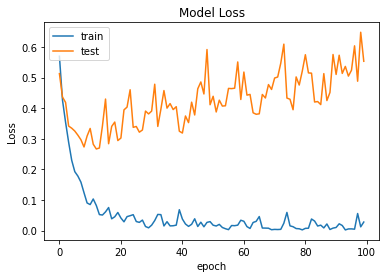

In [78]:
# summarize history for Loss
plt.plot(mod2.history["loss"])
plt.plot(mod2.history["val_loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

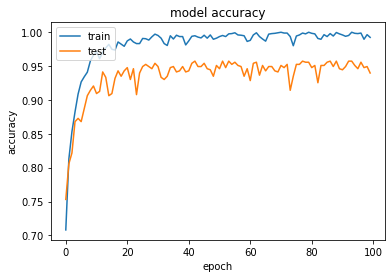

In [79]:
# summarize history for accuracy
plt.plot(mod2.history['accuracy'])
plt.plot(mod2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [80]:
y_pred = model.predict(x_val_feat_inp)
y_pred[:5]

array([[9.2016455e-13, 1.0000000e+00],
       [9.9999702e-01, 1.2158118e-07],
       [6.9124966e-05, 9.9984539e-01],
       [9.9302042e-01, 4.5979619e-03],
       [9.9956095e-01, 8.8855624e-04]], dtype=float32)

In [81]:
#probability = model.predict_proba(x_val_feat_inp)

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [ ]:
predicted_probabilities = model.predict_generator(x_val_feat_inp)
predicted_probabilities

In [ ]:
p_round = np.round(predicted_probabilities*100,2)

In [ ]:

print(np.round(predicted_probabilities*100,2))

In [ ]:
#from statistics import mean
print("mean of arr : ", np.mean(p_round))

In [ ]:
np.argmax(predicted_probabilities)

In [ ]:
tf.keras.metrics.Accuracy(
    name='accuracy', dtype=None
)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score # metrics


In [ ]:
print(accuracy_score(y_test, y_pred))

In [ ]:

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [120]:
y_predict = np.argmax(model.predict(x_val_feat_inp), axis=-1)
y_predict

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,

In [ ]:
len(y_predict)

In [ ]:
final_data = [temp_N,temp_TB,df_train_N_aug, df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

In [ ]:
#%% TRAIN LABEL SEPARATION

train_data = final_data['image']
labels = final_data['label']

In [ ]:
#%% SPLITTING INTO TRAIN AND TEST SET, TRAIN SET WILL BE FURTHER SPLIT INTO TRAIN AND VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train_data, labels,
                                                  test_size = 0.2,
                                                  stratify = labels,
                                                  shuffle = True,
                                                  random_state = 42)

print('length X_train:', len(X_train))
print('length y_train:', len(y_train))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

In [ ]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_pred_round_int = np.asarray(y_pred)

In [ ]:
len(y_pred_round_int)

In [ ]:
type(y_pred_round_int)

In [119]:
type(y_test)

numpy.ndarray

In [ ]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_pred_classes

# ######################

In [118]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [83]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_val_feat_inp)
Y_pred

array([[9.2016455e-13, 1.0000000e+00],
       [9.9999702e-01, 1.2158118e-07],
       [6.9124966e-05, 9.9984539e-01],
       ...,
       [9.6307528e-01, 2.7040929e-02],
       [8.7078214e-03, 9.9508119e-01],
       [2.0515195e-01, 8.4025973e-01]], dtype=float32)

In [84]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_pred_classes

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,

In [85]:
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [88]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)
print("confusion matrix: ")
print(confusion_mtx)

confusion matrix: 
[[293  21]
 [ 17 297]]


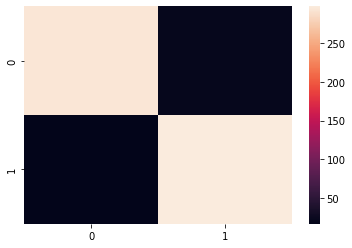

In [89]:
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

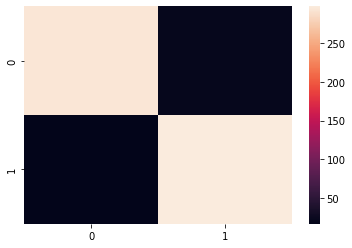

In [96]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the validation dataset
Y_pred = model.predict(x_val_feat_inp)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes) 

# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

In [ ]:
mod2 = model.fit(x_train_feat_inp, y_train,
                batch_size=30, verbose=1, 
                 validation_data=(x_val_feat_inp,y_test), epochs=100) 

In [92]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

NameError: name 'Y_true' is not defined

In [93]:
#print(accuracy_score(y_pred.round(),y_test))
cm = confusion_matrix(y_pred_round_int,y_test)
cm

NameError: name 'y_pred_round_int' is not defined